<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/debiasing_facial_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

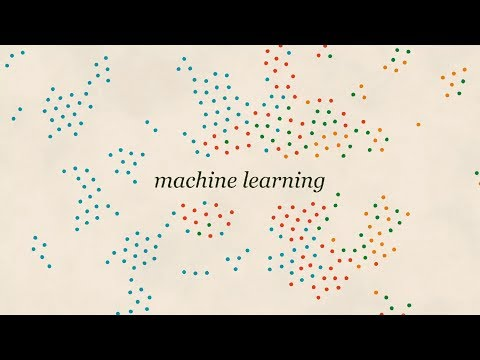

In [0]:
# project: Debiasing Facial Detection System from MIT
# biased data leads to biased result

# why unbias is important:
from IPython.display import YouTubeVideo
YouTubeVideo('59bMh59JQDo')

In [6]:
# address algorithmic bias
# we will build a facial detection model that learns the latent variables 
# underlying face image datasets and use this to re-sample the 
# training data

import tensorflow as tf
tf.enable_eager_execution()

import functools
import matplotlib.pyplot as plt
import numpy as np
import pdb

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

# Import the necessary class-specific utility files for this lab
import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


In [9]:
# classification: face / not a face
# dataset
# positive training data: CelebA
# negative training data: ImageNet
# test                  : Pilot Parliaments Benchmark


path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = util.TrainingDatasetLoader(path_to_training_data)

1263902720/1263889489 [==============================] - 29s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [0]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [24]:
np.where(labels==1)

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

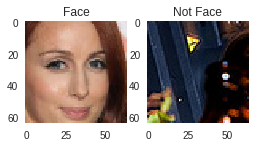

In [28]:
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 20
idx_not_face = 11

plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(face_images[idx_face])
plt.title('Face')
plt.grid(False)

plt.subplot(1,2,2)
plt.imshow(not_face_images[idx_not_face])
plt.title('Not Face')
plt.grid(False)

In [30]:
images[0].shape

(64, 64, 3)

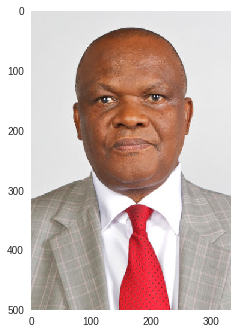

In [32]:
ppb = util.PPBFaceEvaluator(skip=4)
gender = 'male'
skin_color = 'darker'

img = ppb.get_sample_faces_from_demographic(gender, skin_color)
plt.imshow(img)
plt.grid(False)

In [33]:
n_outputs = 1
n_filters =12

def make_standard_classifier():
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  
  model = tf.keras.Sequential([
      Conv2D(filters=1*n_filters, kernel_size=[5,5], strides=[2,2],input_shape=(64,64,3)),
      BatchNormalization(),
      
      Conv2D(filters=2*n_filters, kernel_size=[5,5], strides=[2,2],input_shape=(64,64,3)),
      BatchNormalization(),
      
      Conv2D(filters=4*n_filters, kernel_size=[3,3], strides=[2,2],input_shape=(64,64,3)),
      BatchNormalization(),
      
      Conv2D(filters=6*n_filters, kernel_size=[3,3], strides=[1,1],input_shape=(64,64,3)),
      BatchNormalization(),
      
      Flatten(),
      Dense(1, activation=None),
      tf.keras.layers.Dropout(0.5)
  ])
  return model

standard_classifier = make_standard_classifier()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
standard_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 12)        912       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 12)        48        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 24)        7224      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16, 16, 24)        96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 48)          10416     
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 72)          31176     
__________

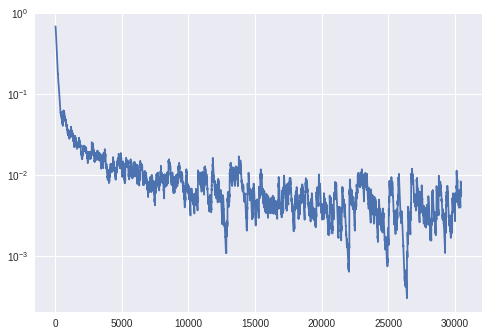

100%|######################################|Time:  0:02:19  Epoch: 9 Loss: 0.00


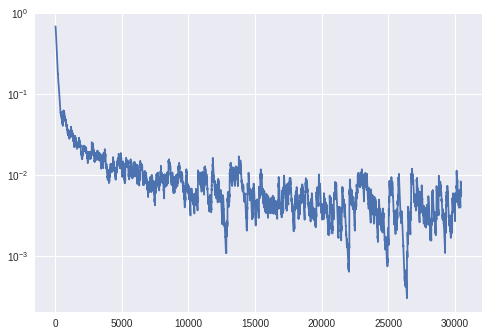

In [36]:
batch_size = 36
num_epochs = 10
learning_rate = 1e-3

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss_history = util.LossHistory(smoothing_factor=0.99)
plotter = util.PeriodicPlotter(sec=2,scale='semilogy')

# The training loop
for epoch in range(num_epochs):
  custom_msg = util.custom_progress_text('Epoch: %(epoch).0f Loss: %(loss)2.2f')
  bar = util.create_progress_bar(custom_msg)
  
  for idx in bar(range(loader.get_train_size() // batch_size)):
    x, y = loader.get_batch(batch_size)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
      logits = standard_classifier(x)
      loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
      
    custom_msg.update_mapping(epoch=epoch, loss=loss_value.numpy().mean())
    # Backpropagation
    grads = tape.gradient(loss_value, standard_classifier.variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.variables), global_step=tf.train.get_or_create_global_step())
    
    loss_history.append(loss_value.numpy().mean())
    plotter.plot(loss_history.get())

In [37]:
# Evaluate on a subset of CeleA+ImageNet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print('Standard CNN accuracy on (potentially biased training set: {:.4f})'.format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased training set: 0.9998)


In [0]:
# impressive

In [38]:
# Evaluate on PPB dataset 
standard_cnn_accuracy = []
for skin_color in ['lighter', 'darker']:
  for gender in ['male', 'female']:
    standard_cnn_accuracy.append(ppb.evaluate([standard_classifier], gender, skin_color, from_logit=True)[0])
    print
    print '{} {}: {}'.format(gender, skin_color, standard_cnn_accuracy[-1])

100% (97 of 97) |########################| Elapsed Time: 0:01:18 Time:  0:01:18
N/A% (0 of 72) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male lighter: 0.876288659794


100% (72 of 72) |########################| Elapsed Time: 0:00:56 Time:  0:00:56
N/A% (0 of 78) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


female lighter: 0.833333333333


100% (78 of 78) |########################| Elapsed Time: 0:01:00 Time:  0:01:00
N/A% (0 of 71) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


male darker: 0.769230769231


100% (71 of 71) |########################| Elapsed Time: 0:00:55 Time:  0:00:55



female darker: 0.859154929577


**probably a sign of bias**

**male darker has relatively lower accuracy **


##DB-VAE

**Debiasing variational Autoencoder**

In [0]:
# Function to calculate VAE loss given an input x, reconstructed output x_pred,
# encoded means mu, encoded log of standard deviation logsigma, and weight parameter 
# for the latent loss
def vae_loss_function(x, x_pred, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_mean(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean((x-x_pred)**2, axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_value

def sampling2(args):
  z_mean, z_logsigma = args
  batch = z_mean.shape[0]
  dim = z_mean.shape[1]
  
  epsilon = tf.random_normal(shape=(batch, dim))
  return z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

def sampling(args):
    z_mean, z_logsigma = args
    batch = z_mean.shape[0]
    dim = z_mean.shape[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = tf.random_normal(shape=(batch, dim))
    '''TODO: Define the reparameterization computation!'''
    return z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

In [0]:
# Loss function for DB-VAE
def debiasing_loss_function(x, x_pred, y, y_logit, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  face_mask = tf.cast(tf.equal(y,1), tf.float32)
  
  total_loss = tf.reduce_mean(classification_loss + face_mask * vae_loss)
  
  return total_loss, classification_loss

In [0]:
# DB-VAE Architecture

latent_dim = 100
n_filters = 12
def make_face_encoder_network():
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding = 'same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  
  inputs = tf.keras.layers.Input(shape=(64,64,3))
  
  hidden = Conv2D(filters=1*n_filters, kernel_size=[5,5], strides=[2,2])(inputs)
  hidden = BatchNormalization()(hidden)
  hideen = Conv2D(filters=2*n_filters, kernel_size=[5,5], strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2D(filters=4*n_filters, kernel_size=[3,3], strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2D(filters=6*n_filters, kernel_size=[3,3], strides=[1,1])(hidden)
  hidden = BatchNormalization()(hidden)
  
  hidden = Flatten(name='flatten')(hidden)
  
  # Encoder outputs
  # y_logits: supervised class classification
  # z_mean: means in the latent space
  # z_logsigma: standard deviations in the latent space
  y_logit = Dense(1, activation=None, name='y_logit')(hidden)
  z_mean = Dense(latent_dim, name='z_mean')(hidden)
  z_logsigma = Dense(latent_dim, name='z_logsigma')(hidden)
  
  # since we always use batch, there is a batch in the sampling function
  
  # use reparameterization trick to sample from latent space
  z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_logsigma])
  # define the outputs that the encoder model should return
  outputs = [y_logit, z_mean, z_logsigma, z]
  # finalize the encoder model
  encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')
  
  # get the shape of the final convolutional output (right before the flatten)
  flatten_layer_idx = encoder.layers.index(encoder.get_layer('flatten'))
  pre_flatten_shape = encoder.layers[flatten_layer_idx-1].get_output_at(0).shape[1:]
  
  return encoder, inputs, outputs, pre_flatten_shape
  

In [0]:
def make_face_encoder_network_debug():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    inputs = tf.keras.layers.Input(shape=(64,64,3))
    
    hidden = Conv2D(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2])(inputs)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=2*n_filters, kernel_size=[5,5],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=4*n_filters, kernel_size=[3,3],  strides=[2,2])(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv2D(filters=6*n_filters, kernel_size=[3,3],  strides=[1,1])(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = Flatten(name='flatten')(hidden)
#     hidden = Dense(128)(hidden)
    
    '''Encoder outputs:
        y_logit: supervised class prediction
        z_mean: means in the latent space
        z_logsigma: standard deviations in the latent space'''
    y_logit = Dense(1, activation=None, name='y_logit')(hidden)
    z_mean = Dense(latent_dim, name='z_mean')(hidden)
    z_logsigma = Dense(latent_dim, name='z_logsigma')(hidden)

    # use reparameterization trick to sample from the latent space
    z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_logsigma])

    # define the outputs that the encoder model should return
    outputs = [y_logit, z_mean, z_logsigma, z]
    # finalize the encoder model
    encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')

    # get the shape of the final convolutional output (right before the flatten)
    flatten_layer_idx = encoder.layers.index(encoder.get_layer('flatten'))
    pre_flatten_shape = encoder.layers[flatten_layer_idx-1].get_output_at(0).shape[1:]
    
    return encoder, inputs, outputs, pre_flatten_shape

In [0]:
# Define the decoder network for the DB-VAE
def make_face_decoder_network(pre_flatten_shape):
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  
  latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
  
  hidden = Dense(tf.reduce_prod(pre_flatten_shape))(latent_inputs) # this one is pretty intresting, the encoder part is just flatten, but here we will use Dense and learn parameters, then reshape back the the second last output of encoder
  hidden = tf.keras.layers.Reshape(pre_flatten_shape)(hidden)
  
  # series of deconvolutional layers with batch normalization
  hidden = Conv2DTranspose(filters=4*n_filters, kernel_size=[3,3], strides=[1,1])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=2*n_filters, kernel_size=[3,3], strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Conv2DTranspose(filters=1*n_filters, kernel_size=[5,5], strides=[2,2])(hidden)
  hidden = BatchNormalization()(hidden)
  
  x_hat = Conv2DTranspose(filters=3, kernel_size=[5,5], strides=[2,2])(hidden)
  
  # instantiate decoder model
  decoder = tf.keras.Model(inputs=latent_inputs,outputs=x_hat,name='decoder')
  return decoder

In [13]:
encoder, inputs, outputs, pre_flatten_shape = make_face_encoder_network()
decoder = make_face_decoder_network(pre_flatten_shape)

# initialize the models
encoder_output = encoder(inputs)
y_logit, z_mean, z_logsigma, z = encoder_output
reconstructed_inputs = decoder(z)

TypeError: ignored